[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/drive/1Tvu8hmhKokIXkE_e_JgvyYyWbATwJ35P?usp=sharing)

### bese

In [ ]:
import tensorflow as tf

# Get the GPU device name.
device_name = tf.test.gpu_device_name()

# The device name should look like the following:
if device_name == '/device:GPU:0':
    print('Found GPU at: {}'.format(device_name))
else:
    raise SystemError('GPU device not found')

Found GPU at: /device:GPU:0


In [ ]:
import torch

# If there's a GPU available...
if torch.cuda.is_available():    

    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla T4


In [ ]:
import pandas as pd
train = pd.read_csv("/content/drive/MyDrive/LTP-keypoints/train.csv")
dev = pd.read_csv("/content/drive/MyDrive/LTP-keypoints/dev.csv")
test = pd.read_csv("/content/drive/MyDrive/LTP-keypoints/test.csv")

In [ ]:
for split in [train,dev,test]:
  for i in split.index:
    arg = split['argument'][i]
    key = split['key_point'][i]
    prompt = f"The argument is \"{arg}\" The keypoint is \"{key}\" The argument and the keypoint are"
    split.at[i, 'pair'] = prompt

In [ ]:
print(train['pair'][0])

The argument is "a person created through cloning could potentially have developmental problems caused by imperfections in the cloning process." The keypoint is "Cloning is not understood enough yet" The argument and the keypoint are


In [ ]:
pairs_train = train.pair.values
labels_train = train.label.values

pairs_dev = dev.pair.values
labels_dev = dev.label.values

pairs_test = test.pair.values
labels_test = test.label.values

In [ ]:
from transformers import BertTokenizer

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [ ]:
max_len = 0

for split in [pairs_train,pairs_dev,pairs_test]:
  for pair in split:

      # Tokenize the text and add `[CLS]` and `[SEP]` tokens.
      input_ids = tokenizer.encode(pair, add_special_tokens=True)

      # Update the maximum sentence length.
      max_len = max(max_len, len(input_ids))

print('Max sentence length: ', max_len)

Max sentence length:  90


In [ ]:
# Tokenize all of the sentences and map the tokens to thier word IDs.
input_ids_train = []
attention_masks_train = []

# For every sentence...
for pair in pairs_train:
    # `encode_plus` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    #   (5) Pad or truncate the sentence to `max_length`
    #   (6) Create attention masks for [PAD] tokens.
    encoded_dict = tokenizer.encode_plus(
                        pair,     # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = 90,   # Pad & truncate all sentences.
                        pad_to_max_length = True,
                        return_attention_mask = True,   # Construct attn. masks.
                        return_tensors = 'pt',     # Return pytorch tensors.
                   )
    
    # Add the encoded sentence to the list.    
    input_ids_train.append(encoded_dict['input_ids'])
    
    # And its attention mask (simply differentiates padding from non-padding).
    attention_masks_train.append(encoded_dict['attention_mask'])

# Convert the lists into tensors.
input_ids_train = torch.cat(input_ids_train, dim=0)
attention_masks_train = torch.cat(attention_masks_train, dim=0)
labels_train = torch.tensor(labels_train)

# Print sentence 0, now as a list of IDs.
print('Original: ', pairs_train[0])
print('Token IDs:', input_ids_train[0])

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2291: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


Original:  The argument is "a person created through cloning could potentially have developmental problems caused by imperfections in the cloning process." The keypoint is "Cloning is not understood enough yet" The argument and the keypoint are
Token IDs: tensor([  101,  1996,  6685,  2003,  1000,  1037,  2711,  2580,  2083, 18856,
        13369,  2071,  9280,  2031, 13908,  3471,  3303,  2011, 29238,  8496,
         1999,  1996, 18856, 13369,  2832,  1012,  1000,  1996,  3145,  8400,
         2003,  1000, 18856, 13369,  2003,  2025,  5319,  2438,  2664,  1000,
         1996,  6685,  1998,  1996,  3145,  8400,  2024,   102,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0])


In [ ]:
# Tokenize all of the sentences and map the tokens to thier word IDs.
input_ids_dev = []
attention_masks_dev = []

for pair in pairs_dev:
    encoded_dict = tokenizer.encode_plus(
                        pair,     # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = 90,   # Pad & truncate all sentences.
                        pad_to_max_length = True,
                        return_attention_mask = True,   # Construct attn. masks.
                        return_tensors = 'pt',     # Return pytorch tensors.
                   )
        
    input_ids_dev.append(encoded_dict['input_ids'])
    

    attention_masks_dev.append(encoded_dict['attention_mask'])


input_ids_dev = torch.cat(input_ids_dev, dim=0)
attention_masks_dev = torch.cat(attention_masks_dev, dim=0)
labels_dev = torch.tensor(labels_dev)


print('Original: ', pairs_dev[0])
print('Token IDs:', input_ids_dev[0])

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2291: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


Original:  The argument is "a man or woman has the right to do what they wish with their body, and if they choose to sell it for sex, the government should not interfere." The keypoint is "Legalizing sex work boosts the economy" The argument and the keypoint are
Token IDs: tensor([  101,  1996,  6685,  2003,  1000,  1037,  2158,  2030,  2450,  2038,
         1996,  2157,  2000,  2079,  2054,  2027,  4299,  2007,  2037,  2303,
         1010,  1998,  2065,  2027,  5454,  2000,  5271,  2009,  2005,  3348,
         1010,  1996,  2231,  2323,  2025, 15115,  1012,  1000,  1996,  3145,
         8400,  2003,  1000,  3423,  6026,  3348,  2147, 12992,  2015,  1996,
         4610,  1000,  1996,  6685,  1998,  1996,  3145,  8400,  2024,   102,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0])


In [ ]:
from torch.utils.data import TensorDataset
train_dataset = TensorDataset(input_ids_train, attention_masks_train, labels_train)
dev_dataset = TensorDataset(input_ids_dev, attention_masks_dev, labels_dev)

In [ ]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

# The DataLoader needs to know our batch size for training, so we specify it 
# here. For fine-tuning BERT on a specific task, the authors recommend a batch 
# size of 16 or 32.
batch_size = 32

# Create the DataLoaders for our training and validation sets.
# We'll take training samples in random order. 
train_dataloader = DataLoader(
            train_dataset,  # The training samples.
            sampler = RandomSampler(train_dataset), # Select batches randomly
            batch_size = batch_size # Trains with this batch size.
        )

# For validation the order doesn't matter, so we'll just read them sequentially.
dev_dataloader = DataLoader(
            dev_dataset, # The validation samples.
            sampler = SequentialSampler(dev_dataset), # Pull out batches sequentially.
            batch_size = batch_size # Evaluate with this batch size.
        )

In [ ]:
for step, batch in enumerate(train_dataloader):
  print(batch[2])

In [ ]:
from transformers import BertForSequenceClassification, AdamW, BertConfig

# Load BertForSequenceClassification, the pretrained BERT model with a single 
# linear classification layer on top. 
model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased", # Use the 12-layer BERT model, with an uncased vocab.
    num_labels = 2, # The number of output labels--2 for binary classification.
                    # You can increase this for multi-class tasks.   
    output_attentions = False, # Whether the model returns attentions weights.
    output_hidden_states = False, # Whether the model returns all hidden-states.
)

# Tell pytorch to run this model on the GPU.
model.cuda()

Downloading:   0%|          | 0.00/420M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [ ]:
# Note: AdamW is a class from the huggingface library (as opposed to pytorch) 
# I believe the 'W' stands for 'Weight Decay fix"
optimizer = AdamW(model.parameters(),
                  lr = 2e-5, # args.learning_rate - default is 5e-5, our notebook had 2e-5
                  eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                )

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


In [ ]:
from transformers import get_linear_schedule_with_warmup

# Number of training epochs. The BERT authors recommend between 2 and 4. 

epochs = 3

# Total number of training steps is [number of batches] x [number of epochs]. 
# (Note that this is not the same as the number of training samples).
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)

In [ ]:
import numpy as np

# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [ ]:
import time
import datetime

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [ ]:
import random
import numpy as np

# This training code is based on the `run_glue.py` script here:
# https://github.com/huggingface/transformers/blob/5bfcd0485ece086ebcbed2d008813037968a9e58/examples/run_glue.py#L128

# Set the seed value all over the place to make this reproducible.
seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# We'll store a number of quantities such as training and validation loss, 
# validation accuracy, and timings.
training_stats = []

# Measure the total training time for the whole run.
total_t0 = time.time()

# For each epoch...
for epoch_i in range(0, epochs):
    
    # ========================================
    #               Training
    # ========================================
    
    # Perform one full pass over the training set.

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    # Measure how long the training epoch takes.
    t0 = time.time()

    # Reset the total loss for this epoch.
    total_train_loss = 0

    # Put the model into training mode. Don't be mislead--the call to 
    # `train` just changes the *mode*, it doesn't *perform* the training.
    # `dropout` and `batchnorm` layers behave differently during training
    # vs. test (source: https://stackoverflow.com/questions/51433378/what-does-model-train-do-in-pytorch)
    model.train()

    # For each batch of training data...
    for step, batch in enumerate(train_dataloader):

        # Progress update every 40 batches.
        if step % 40 == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)
            
            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        # Unpack this training batch from our dataloader. 
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using the 
        # `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        # Always clear any previously calculated gradients before performing a
        # backward pass. PyTorch doesn't do this automatically because 
        # accumulating the gradients is "convenient while training RNNs". 
        # (source: https://stackoverflow.com/questions/48001598/why-do-we-need-to-call-zero-grad-in-pytorch)
        model.zero_grad()        

        # Perform a forward pass (evaluate the model on this training batch).
        # In PyTorch, calling `model` will in turn call the model's `forward` 
        # function and pass down the arguments. The `forward` function is 
        # documented here: 
        # https://huggingface.co/transformers/model_doc/bert.html#bertforsequenceclassification
        # The results are returned in a results object, documented here:
        # https://huggingface.co/transformers/main_classes/output.html#transformers.modeling_outputs.SequenceClassifierOutput
        # Specifically, we'll get the loss (because we provided labels) and the
        # "logits"--the model outputs prior to activation.
        result = model(b_input_ids, 
                       token_type_ids=None, 
                       attention_mask=b_input_mask, 
                       labels=b_labels,
                       return_dict=True)

        loss = result.loss
        logits = result.logits

        # Accumulate the training loss over all of the batches so that we can
        # calculate the average loss at the end. `loss` is a Tensor containing a
        # single value; the `.item()` function just returns the Python value 
        # from the tensor.
        total_train_loss += loss.item()

        # Perform a backward pass to calculate the gradients.
        loss.backward()

        # Clip the norm of the gradients to 1.0.
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # Update parameters and take a step using the computed gradient.
        # The optimizer dictates the "update rule"--how the parameters are
        # modified based on their gradients, the learning rate, etc.
        optimizer.step()

        # Update the learning rate.
        scheduler.step()

    # Calculate the average loss over all of the batches.
    avg_train_loss = total_train_loss / len(train_dataloader)            
    
    # Measure how long this epoch took.
    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(training_time))
        
    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set.

    print("")
    print("Running Validation...")

    t0 = time.time()

    # Put the model in evaluation mode--the dropout layers behave differently
    # during evaluation.
    model.eval()

    # Tracking variables 
    total_eval_accuracy = 0
    total_eval_loss = 0
    nb_eval_steps = 0

    # Evaluate data for one epoch
    for batch in dev_dataloader:
        
        # Unpack this training batch from our dataloader. 
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using 
        # the `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        
        # Tell pytorch not to bother with constructing the compute graph during
        # the forward pass, since this is only needed for backprop (training).
        with torch.no_grad():        

            # Forward pass, calculate logit predictions.
            # token_type_ids is the same as the "segment ids", which 
            # differentiates sentence 1 and 2 in 2-sentence tasks.
            result = model(b_input_ids, 
                           token_type_ids=None, 
                           attention_mask=b_input_mask,
                           labels=b_labels,
                           return_dict=True)

        # Get the loss and "logits" output by the model. The "logits" are the 
        # output values prior to applying an activation function like the 
        # softmax.
        loss = result.loss
        logits = result.logits
            
        # Accumulate the validation loss.
        total_eval_loss += loss.item()

        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        # Calculate the accuracy for this batch of test sentences, and
        # accumulate it over all batches.
        total_eval_accuracy += flat_accuracy(logits, label_ids)
        

    # Report the final accuracy for this validation run.
    avg_val_accuracy = total_eval_accuracy / len(dev_dataloader)
    print("  Accuracy: {0:.2f}".format(avg_val_accuracy))

    # Calculate the average loss over all of the batches.
    avg_val_loss = total_eval_loss / len(dev_dataloader)
    
    # Measure how long the validation run took.
    validation_time = format_time(time.time() - t0)
    
    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))

    # Record all statistics from this epoch.
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Valid. Accur.': avg_val_accuracy,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )

print("")
print("Training complete!")

print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))


======== Epoch 1 / 3 ========
Training...
  Batch    40  of    532.    Elapsed: 0:00:18.
  Batch    80  of    532.    Elapsed: 0:00:37.
  Batch   120  of    532.    Elapsed: 0:00:57.
  Batch   160  of    532.    Elapsed: 0:01:16.
  Batch   200  of    532.    Elapsed: 0:01:36.
  Batch   240  of    532.    Elapsed: 0:01:56.
  Batch   280  of    532.    Elapsed: 0:02:16.
  Batch   320  of    532.    Elapsed: 0:02:36.
  Batch   360  of    532.    Elapsed: 0:02:56.
  Batch   400  of    532.    Elapsed: 0:03:16.
  Batch   440  of    532.    Elapsed: 0:03:36.
  Batch   480  of    532.    Elapsed: 0:03:56.
  Batch   520  of    532.    Elapsed: 0:04:16.

  Average training loss: 0.33
  Training epcoh took: 0:04:22

Running Validation...
  Accuracy: 0.83
  Validation Loss: 0.43
  Validation took: 0:00:17

======== Epoch 2 / 3 ========
Training...
  Batch    40  of    532.    Elapsed: 0:00:20.
  Batch    80  of    532.    Elapsed: 0:00:40.
  Batch   120  of    532.    Elapsed: 0:01:00.
  Batch  

In [ ]:
import pandas as pd

# Display floats with two decimal places.
pd.set_option('precision', 2)

# Create a DataFrame from our training statistics.
df_stats = pd.DataFrame(data=training_stats)

# Use the 'epoch' as the row index.
df_stats = df_stats.set_index('epoch')

# A hack to force the column headers to wrap.
#df = df.style.set_table_styles([dict(selector="th",props=[('max-width', '70px')])])

# Display the table.
df_stats

,Training Loss,Valid. Loss,Valid. Accur.,Training Time,Validation Time
epoch,,,,,
1,0.33,0.43,0.83,0:04:22,0:00:17
2,0.16,0.49,0.82,0:04:26,0:00:17
3,0.09,0.57,0.84,0:04:26,0:00:17


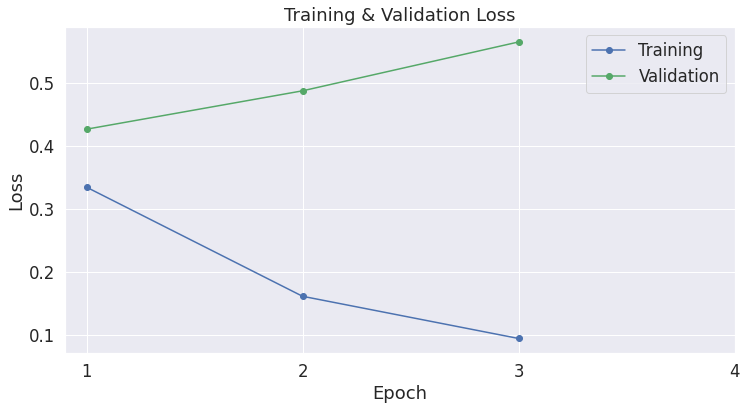

In [ ]:
import matplotlib.pyplot as plt
% matplotlib inline

import seaborn as sns

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(df_stats['Training Loss'], 'b-o', label="Training")
plt.plot(df_stats['Valid. Loss'], 'g-o', label="Validation")

# Label the plot.
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks([1, 2, 3, 4])

plt.show()

In [ ]:
# Tokenize all of the sentences and map the tokens to thier word IDs.
input_ids = []
attention_masks = []

# For every sentence...
for pair in pairs_test:
    # `encode_plus` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    #   (5) Pad or truncate the sentence to `max_length`
    #   (6) Create attention masks for [PAD] tokens.
    encoded_dict = tokenizer.encode_plus(
                        pair,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = 90,           # Pad & truncate all sentences.
                        pad_to_max_length = True,
                        return_attention_mask = True,   # Construct attn. masks.
                        return_tensors = 'pt',     # Return pytorch tensors.
                   )
    
    # Add the encoded sentence to the list.    
    input_ids.append(encoded_dict['input_ids'])
    
    # And its attention mask (simply differentiates padding from non-padding).
    attention_masks.append(encoded_dict['attention_mask'])

# Convert the lists into tensors.
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(labels_test)

# Set the batch size.  
batch_size = 32  

# Create the DataLoader.
prediction_data = TensorDataset(input_ids, attention_masks, labels)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2291: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [ ]:
# Prediction on test set

print('Predicting labels for {:,} test sentences...'.format(len(input_ids)))

# Put model in evaluation mode
model.eval()

# Tracking variables 
predictions , true_labels = [], []

# Predict 
for batch in prediction_dataloader:
  # Add batch to GPU
  batch = tuple(t.to(device) for t in batch)
  
  # Unpack the inputs from our dataloader
  b_input_ids, b_input_mask, b_labels = batch
  
  # Telling the model not to compute or store gradients, saving memory and 
  # speeding up prediction
  with torch.no_grad():
      # Forward pass, calculate logit predictions.
      result = model(b_input_ids, 
                     token_type_ids=None, 
                     attention_mask=b_input_mask,
                     return_dict=True)

  logits = result.logits

  # Move logits and labels to CPU
  logits = logits.detach().cpu().numpy()
  label_ids = b_labels.to('cpu').numpy()
  
  # Store predictions and true labels
  predictions.append(logits)
  true_labels.append(label_ids)

print('    DONE.')

Predicting labels for 4,171 test sentences...
    DONE.


In [ ]:
print('Positive samples: %d of %d (%.2f%%)' % (labels_test.sum(), len(labels_test), (labels_test.sum() / len(labels_test) * 100.0)))

Positive samples: 760 of 4171 (18.22%)
